# Robust Linear Models

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


## Estimation

Load data:

In [13]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [14]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.79189854 0.11100521 0.30293016 0.12864961]
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 08 Aug 2021                                         
Time:                        23:05:08                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Huber's T norm with 'H2' covariance matrix

In [15]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.08950419 0.11945975 0.32235497 0.11796313]


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [16]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  [-40.8817957    0.79276138   1.04857556  -0.13360865]


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [17]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [18]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.06616469  0.50971347 -0.01196798]
[0.4528524  0.0699143  0.00618634]
[ 4.76696507  5.02186647  5.2727802   5.51970627  5.76264467  6.0015954
  6.23655846  6.46753386  6.69452159  6.91752166  7.13653406  7.35155879
  7.56259585  7.76964525  7.97270698  8.17178105  8.36686745  8.55796618
  8.74507724  8.92820064  9.10733637  9.28248444  9.45364484  9.62081757
  9.78400263  9.94320003 10.09840976 10.24963183 10.39686623 10.54011296
 10.67937202 10.81464342 10.94592715 11.07322322 11.19653162 11.31585235
 11.43118542 11.54253081 11.64988855 11.75325861 11.85264101 11.94803574
 12.03944281 12.1268622  12.21029394 12.289738   12.3651944  12.43666313
 12.5041442  12.56763759]


Estimate RLM:

In [19]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 4.99971997e+00  4.97834554e-01 -1.83929791e-03]
[0.13329065 0.02057828 0.00182086]


Draw a plot to compare OLS estimates to the robust estimates:

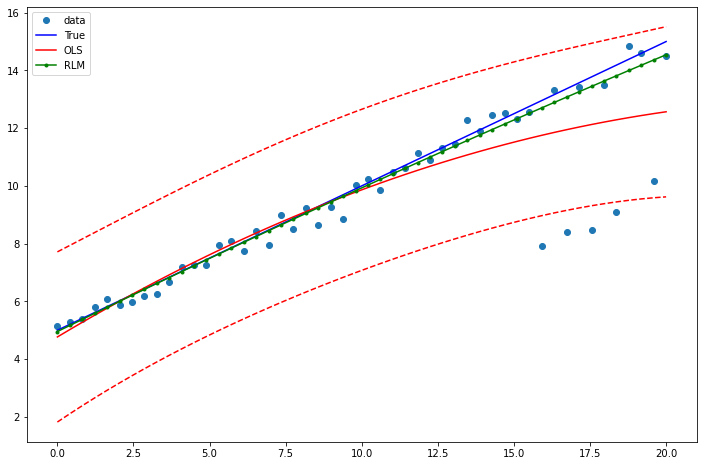

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()['obs_ci_lower']
iv_u = pred_ols.summary_frame()['obs_ci_upper']

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [21]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.54854774 0.39003363]
[0.38867251 0.03348959]


Estimate RLM:

In [22]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.06034383 0.48054972]
[0.11069671 0.00953808]


Draw a plot to compare OLS estimates to the robust estimates:

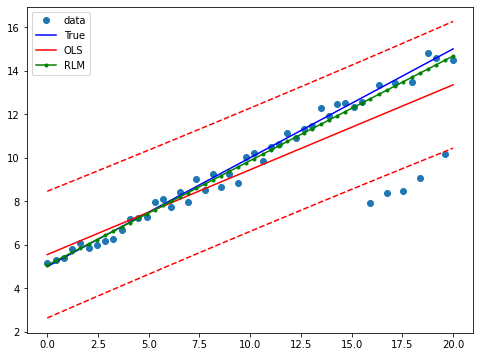

In [23]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()['obs_ci_lower']
iv_u = pred_ols.summary_frame()['obs_ci_upper']

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")